# ADOPTION SPEED AND FEATURE IMPORTANCE

IMPORTING PACKAGES

In [16]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE, VarianceThreshold, SelectFromModel
from sklearn.feature_selection import SelectKBest, mutual_info_regression, mutual_info_classif, chi2
from sklearn.metrics import f1_score,classification_report, confusion_matrix 
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.pyplot as plt
import time
from operator import itemgetter

Hyperparameters

In [17]:
feat_select=1                                       #Control Switch for Feature Selection
fs_type=2                                          #Feature Selection type (1=Stepwise Backwards Removal, 2=Wrapper Select, 3=Univariate Selection)
lv_filter=0                                         #Control switch for low variance filter on features
rand_st=1                                           #Set Random State variable for randomizing splits on runs        
all_features=0
k_cnt=10
random_forest=1
gradient_boosting=1
svm=1
all_features=1

Importing dataset and train/test 

In [18]:
####CONSTRUCTING TRAIN AND TEST####
infile=pd.read_csv('dataset6.csv')

data=pd.DataFrame(infile,columns=['Type', 'Gender', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Fee', 'VideoAmt',
       'PhotoAmt', 'Count_of_listings',
       'Has_name', 'Mixed', 'Colors', 'Log_Age',
       'state_gdp', 'state_population', 'state_area', 'state_unemployment',
       'state_birth_rate', 'SentMagnitude', 'SentScore','dominant_score'])
target=infile['AdoptionSpeed']
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.3,random_state=rand_st)

Train on all features

In [19]:
####TRAIN ON ALL FEATURES####
if all_features==1:
    clf = RandomForestClassifier(n_estimators=100,criterion='gini',random_state=0)
    clf.fit(data_train,target_train)
    scores_ACC = clf.score(data_test, target_test)                                                                                                                          
    print('Random Forest Acc:', scores_ACC.round(3))
    train_predictions=clf.predict(data_train)
    test_predictions=clf.predict(data_test)
    print("True Distribution:")
    print(pd.value_counts(target, normalize=True).sort_index())
    print("\nTrain Predicted Distribution:")
    print(pd.value_counts(train_predictions, normalize=True).sort_index())
    print("\nTest Predicted Distribution:")
    print(pd.value_counts(test_predictions, normalize=True).sort_index())
    print(confusion_matrix(target_test, test_predictions))  
    print(classification_report(target_test, test_predictions))      
    start_ts=time.time()
    scorers = {'Accuracy': 'accuracy'}                                                                                                                
    clf = RandomForestClassifier(n_estimators=100,criterion='entropy', max_depth=None, min_samples_split=3,random_state=rand_st)
    scores = cross_validate(clf, data, np.ravel(target), scoring=scorers, cv=5)                                                                                              
    scores_Acc = scores['test_Accuracy']      
    print('\n-----Five-fold Cross-validation Results-----\n')                                                                                                                              
    print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                                           
    print("CV Runtime:", time.time()-start_ts)

Random Forest Acc: 0.429
True Distribution:
0    0.039010
1    0.287448
2    0.372775
3    0.300766
Name: AdoptionSpeed, dtype: float64

Train Predicted Distribution:
0    0.039569
1    0.288601
2    0.376326
3    0.295504
dtype: float64

Test Predicted Distribution:
0    0.003928
1    0.266693
2    0.462687
3    0.266693
dtype: float64
[[  5  29  37  25]
 [  3 281 328 113]
 [  0 220 487 221]
 [  2 149 326 320]]
              precision    recall  f1-score   support

           0       0.50      0.05      0.09        96
           1       0.41      0.39      0.40       725
           2       0.41      0.52      0.46       928
           3       0.47      0.40      0.43       797

    accuracy                           0.43      2546
   macro avg       0.45      0.34      0.35      2546
weighted avg       0.43      0.43      0.42      2546


-----Five-fold Cross-validation Results-----

Random Forest Acc: 0.44 (+/- 0.02)
CV Runtime: 5.8028810024261475


Feature selection: low variance, wrapper select, chi-square and feature importance score

In [20]:
####FEATURE SELECTION####
#Low Variance Filter
if lv_filter==1:
    print('--LOW VARIANCE FILTER ON--', '\n')
    header=data_train.columns.tolist()
    #LV Threshold
    sel = VarianceThreshold(threshold=0.5)                                         
    fit_mod=sel.fit(data)
    fitted=sel.transform(data)
    sel_idx=fit_mod.get_support()

    #Get lists of selected and non-selected features (names and indexes)
    temp=[]
    temp_idx=[]
    temp_del=[]
    for i in range(len(header)):
        if sel_idx[i]==1:                                                           #Selected Features get added to temp header
            temp.append(header[i])
            temp_idx.append(i)
        else:                                                                       #Indexes of non-selected features get added to delete array
            temp_del.append(i)
    print('Selected:', temp)
    print('Features (total, selected):', len(header), len(temp))
    print('\n')

    #Filter selected columns from original dataset
    orders=[]
    for i in temp:
        order=header.index(i)
        orders.append(order)
    data=infile.iloc[:,orders]                                

if feat_select==1:
    print('--FEATURE SELECTION ON--', '\n')
    header=data_train.columns.tolist()
    #Wrapper Select via model
    if fs_type==2:
        clf =RandomForestClassifier(n_estimators=100,criterion='entropy', max_depth=None, min_samples_split=3,random_state=rand_st)        
        sel = SelectFromModel(clf, prefit=False, threshold='mean', max_features=None)                   
        print ('Wrapper Select: ')
        fit_mod=sel.fit(data_train, target_train)    
        sel_idx=fit_mod.get_support()
    if fs_type==3:
        #Univariate Feature Selection - Chi-squared
        sel=SelectKBest(chi2,k=k_cnt)
        fit_mod=sel.fit(data, target)                                         #will throw error if any negative values in features, so turn off feature normalization, or switch to mutual_info_classif
        print ('Univariate Feature Selection - Chi2: ')
        sel_idx=fit_mod.get_support()
        #Print ranked variables out sorted
        temp=[]
        scores=fit_mod.scores_
        for i in range(len(header)):            
            temp.append([header[i], float(scores[i])])
        print('Chi2 Ranked Features')
        temp_sort=sorted(temp, key=itemgetter(1), reverse=True)
        for i in range(len(temp_sort)):
            print(i, temp_sort[i][0], ':', temp_sort[i][1])
        print('\n')        
    if fs_type==4:
        clf=RandomForestClassifier(n_estimators=100,criterion='entropy', max_depth=None, min_samples_split=3,random_state=rand_st)
        clf.fit(data_train, target_train)
        print('Feature Importance Feature Selection:') 
        sel_idx=[] #empty erray
        feature_importances=clf.feature_importances_
        ave_importance=round(np.mean(clf.feature_importances_),3)
        for x in feature_importances:
            if x>=ave_importance:
                sel_idx.append(1)
            else:
                sel_idx.append(0)
        temp=[]
        for i in range(len(header)):            
            temp.append([header[i], float(feature_importances[i])])
        print('Feature Importance Ranked Features')
        temp_sort=sorted(temp, key=itemgetter(1), reverse=True)
        for i in range(len(temp_sort)):
            print(i, temp_sort[i][0], ':', temp_sort[i][1])
        print('\n') 
#Get lists of selected and non-selected features (names and indexes)
    temp=[]
    temp_idx=[]
    temp_del=[]
    for i in range(len(header)):
        if sel_idx[i]==1:                                                           #Selected Features get added to temp header
            temp.append(header[i])
            temp_idx.append(i)
        else:                                                                       #Indexes of non-selected features get added to delete array
            temp_del.append(i)
    print('Selected:', temp)
    print('Features (total/selected):', len(header), len(temp))
    print('\n')
    #delete features     
    orders=[]
    for i in temp:
        order=header.index(i)
        orders.append(order)
    data=infile.iloc[:,orders]    


--FEATURE SELECTION ON-- 

Wrapper Select: 
Selected: ['PhotoAmt', 'Count_of_listings', 'Colors', 'Log_Age', 'SentMagnitude', 'SentScore', 'dominant_score']
Features (total/selected): 24 7




New train and test sets with selected features only

In [21]:
data=pd.DataFrame(infile,columns=['PhotoAmt', 'Count_of_listings', 'Log_Age', 'SentMagnitude', 'SentScore', 'dominant_score'])
target=infile['AdoptionSpeed']
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.3,random_state=rand_st)

Random Forest model training and results

In [22]:
if random_forest==1:
    clf = RandomForestClassifier(n_estimators=100,criterion='entropy',random_state=0)
    clf.fit(data_train,target_train)
    scores_ACC = clf.score(data_test, target_test)                                                                                                                          
    print('Random Forest Acc:', scores_ACC.round(3))
    train_predictions=clf.predict(data_train)
    test_predictions=clf.predict(data_test)
    print("True Distribution:")
    print(pd.value_counts(target, normalize=True).sort_index())
    print("\nTrain Predicted Distribution:")
    print(pd.value_counts(train_predictions, normalize=True).sort_index())
    print("\nTest Predicted Distribution:")
    print(pd.value_counts(test_predictions, normalize=True).sort_index())
    print(confusion_matrix(target_test, test_predictions))  
    print(classification_report(target_test, test_predictions))      
    start_ts=time.time()
    scorers = {'Accuracy': 'accuracy'}                                                                                                                
    clf = RandomForestClassifier(n_estimators=100,criterion='entropy', max_depth=None, min_samples_split=3,random_state=rand_st)
    scores = cross_validate(clf, data, np.ravel(target), scoring=scorers, cv=5)                                                                                              
    scores_Acc = scores['test_Accuracy']      
    print('\n-----Five-fold Cross-validation Results-----\n')                                                                                                                              
    print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                                           
    print("CV Runtime:", time.time()-start_ts)

Random Forest Acc: 0.404
True Distribution:
0    0.039010
1    0.287448
2    0.372775
3    0.300766
Name: AdoptionSpeed, dtype: float64

Train Predicted Distribution:
0    0.039737
1    0.288432
2    0.376326
3    0.295504
dtype: float64

Test Predicted Distribution:
0    0.006677
1    0.266693
2    0.465043
3    0.261587
dtype: float64
[[  4  32  43  17]
 [  5 259 336 125]
 [  5 214 475 234]
 [  3 174 330 290]]
              precision    recall  f1-score   support

           0       0.24      0.04      0.07        96
           1       0.38      0.36      0.37       725
           2       0.40      0.51      0.45       928
           3       0.44      0.36      0.40       797

    accuracy                           0.40      2546
   macro avg       0.36      0.32      0.32      2546
weighted avg       0.40      0.40      0.40      2546


-----Five-fold Cross-validation Results-----

Random Forest Acc: 0.41 (+/- 0.02)
CV Runtime: 6.290337085723877


Parameter tuning for random forest

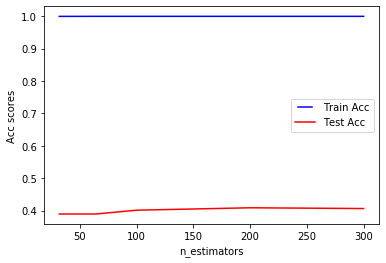

In [23]:
n_estimators = [32, 64, 100, 200,300]
train_results = []
test_results = []
for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1,random_state=rand_st)
   rf.fit(data_train,target_train)
   train_pred = rf.predict(data_train)
   train_acc = rf.score(data_train, target_train)                                                                                                                          
   train_results.append(train_acc)
   test_pred = rf.predict(data_test)
   test_acc = rf.score(data_test, target_test)     
   test_results.append(test_acc)

line1, = plt.plot(n_estimators, train_results, 'b', label='Train Acc')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test Acc')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Acc scores')
plt.xlabel('n_estimators')
plt.show()

In [ ]:
Gradient boosting training and results

In [24]:
if gradient_boosting==1:
    clf =GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=3, min_samples_leaf=1,max_depth=3,random_state=rand_st )
    clf.fit(data_train,target_train)
    scores_ACC = clf.score(data_test, target_test)                                                                                                                          
    print('Gradient Boosting Acc:', scores_ACC.round(3))
    train_predictions=clf.predict(data_train)
    test_predictions=clf.predict(data_test)
    print("True Distribution:")
    print(pd.value_counts(target, normalize=True).sort_index())
    print("\nTrain Predicted Distribution:")
    print(pd.value_counts(train_predictions, normalize=True).sort_index())
    print("\nTest Predicted Distribution:")
    print(pd.value_counts(test_predictions, normalize=True).sort_index())
    print('\nConfusion Matrix')
    print(confusion_matrix(target_test, test_predictions))  
    print('Classification Report')
    print(classification_report(target_test, test_predictions))     
    start_ts=time.time()
    scorers = {'Accuracy': 'accuracy'}                                                                                                                
    clf = RandomForestClassifier(n_estimators=100,criterion='entropy', max_depth=None, min_samples_split=3,random_state=rand_st)
    scores = cross_validate(clf, data, np.ravel(target), scoring=scorers, cv=5)                                                                                              
    scores_Acc = scores['test_Accuracy']      
    print('\n-----Five-fold Cross-validation Results-----\n')                                                                                                                              
    print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                                           
    print("CV Runtime:", time.time()-start_ts)    

Gradient Boosting Acc: 0.391
True Distribution:
0    0.039010
1    0.287448
2    0.372775
3    0.300766
Name: AdoptionSpeed, dtype: float64

Train Predicted Distribution:
0    0.004715
1    0.250884
2    0.558512
3    0.185890
dtype: float64

Test Predicted Distribution:
0    0.003535
1    0.236057
2    0.553810
3    0.206599
dtype: float64

Confusion Matrix
[[  1  24  54  17]
 [  3 229 406  87]
 [  2 197 536 193]
 [  3 151 414 229]]
Classification Report
              precision    recall  f1-score   support

           0       0.11      0.01      0.02        96
           1       0.38      0.32      0.35       725
           2       0.38      0.58      0.46       928
           3       0.44      0.29      0.35       797

    accuracy                           0.39      2546
   macro avg       0.33      0.30      0.29      2546
weighted avg       0.39      0.39      0.37      2546


-----Five-fold Cross-validation Results-----

Random Forest Acc: 0.41 (+/- 0.02)
CV Runtime: 6.127417087

Supported vector machine using rbf kernel training and results

In [25]:
if svm==1:
    clf=SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, probability=False, tol=0.001,random_state=rand_st)
    clf.fit(data_train,target_train)
    scores_ACC = clf.score(data_test, target_test)                                                                                                                          
    print('SVM Acc:', scores_ACC.round(3))
    train_predictions=clf.predict(data_train)
    test_predictions=clf.predict(data_test)
    print("True Distribution:")
    print(pd.value_counts(target, normalize=True).sort_index())
    print("\nTrain Predicted Distribution:")
    print(pd.value_counts(train_predictions, normalize=True).sort_index())
    print("\nTest Predicted Distribution:")
    print(pd.value_counts(test_predictions, normalize=True).sort_index())
    print('\nConfusion Matrix')
    print(confusion_matrix(target_test, test_predictions))  
    print('Classification Report')
    print(classification_report(target_test, test_predictions))     
    start_ts=time.time()
    scorers = {'Accuracy': 'accuracy'}                                                                                                                
    clf = RandomForestClassifier(n_estimators=100,criterion='entropy', max_depth=None, min_samples_split=3,random_state=rand_st)
    scores = cross_validate(clf, data, np.ravel(target), scoring=scorers, cv=5)                                                                                              
    scores_Acc = scores['test_Accuracy']      
    print('\n-----Five-fold Cross-validation Results-----\n')                                                                                                                              
    print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                                           
    print("CV Runtime:", time.time()-start_ts)

SVM Acc: 0.368
True Distribution:
0    0.039010
1    0.287448
2    0.372775
3    0.300766
Name: AdoptionSpeed, dtype: float64

Train Predicted Distribution:
2    0.952012
3    0.047988
dtype: float64

Test Predicted Distribution:
2    0.941084
3    0.058916
dtype: float64

Confusion Matrix
[[  0   0  95   1]
 [  0   0 706  19]
 [  0   0 867  61]
 [  0   0 728  69]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        96
           1       0.00      0.00      0.00       725
           2       0.36      0.93      0.52       928
           3       0.46      0.09      0.15       797

    accuracy                           0.37      2546
   macro avg       0.21      0.26      0.17      2546
weighted avg       0.28      0.37      0.24      2546



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



-----Five-fold Cross-validation Results-----

Random Forest Acc: 0.41 (+/- 0.02)
CV Runtime: 6.47997522354126
